**Question 1**
* Gabriel Cutshaw
* Dante Goldner
* Mattan Tseng
* Hossen Zaremehrjerdi


In [1]:
import numpy as np
import h5py
from einops import rearrange
import matplotlib.pyplot as plt

In [2]:
data_path = "./Combustion_data_ME592_Assignment/Aditya_data/combustion_img_13.mat"
arrays = {}


data = h5py.File(data_path)

for k, v in data.items():
    arrays[k] = np.array(v)


test_set_x = arrays["test_set_x"]
test_set_y = arrays["test_set_y"]
train_set_x = arrays["train_set_x"]
train_set_y = arrays["train_set_y"]
valid_set_x = arrays["valid_set_x"]
valid_set_y = arrays["valid_set_y"]

In [3]:
print("The shape of test x: ", test_set_x.shape)
print("The shape of test y: ", test_set_y.shape)
print("The shape of train x: ", train_set_x.shape)
print("The shape of train y: ", train_set_y.shape)
print("The shape of validation x: ", valid_set_x.shape)
print("The shape of validation y: ", valid_set_y.shape)

The shape of test x:  (25000, 18000)
The shape of test y:  (18000, 1)
The shape of train x:  (25000, 54000)
The shape of train y:  (54000, 1)
The shape of validation x:  (25000, 9000)
The shape of validation y:  (9000, 1)


shape of test array:  (18000, 100, 250)
shape of train array:  (54000, 100, 250)
shape of validation array:  (9000, 100, 250)
Here is one of the images for reference


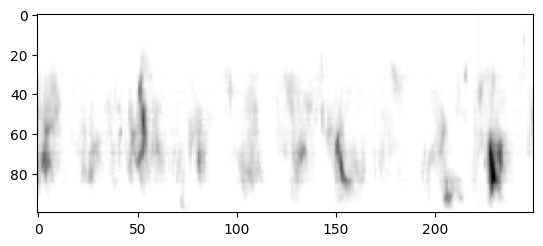

In [14]:
image_shape = (250, 100)

# all of our arrays are strangely formatted. 
# rearrange them to be individual images. 

test_images = rearrange(test_set_x, "(y h) (x w) -> (y x) h w", w = image_shape[0], h = image_shape[1])
train_images = rearrange(train_set_x, "(y h) (x w) -> (y x) h w", w = image_shape[0], h = image_shape[1])
validation_images = rearrange(valid_set_x, "(y h) (x w) -> (y x) h w", w = image_shape[0], h = image_shape[1])
print("shape of test array: ", test_images.shape)
print("shape of train array: ", train_images.shape)
print("shape of validation array: ", validation_images.shape)


plt.imshow(test_images[0, :, :], cmap='Greys')
print("Here is one of the images for reference")


Text(0, 0.5, 'instances')

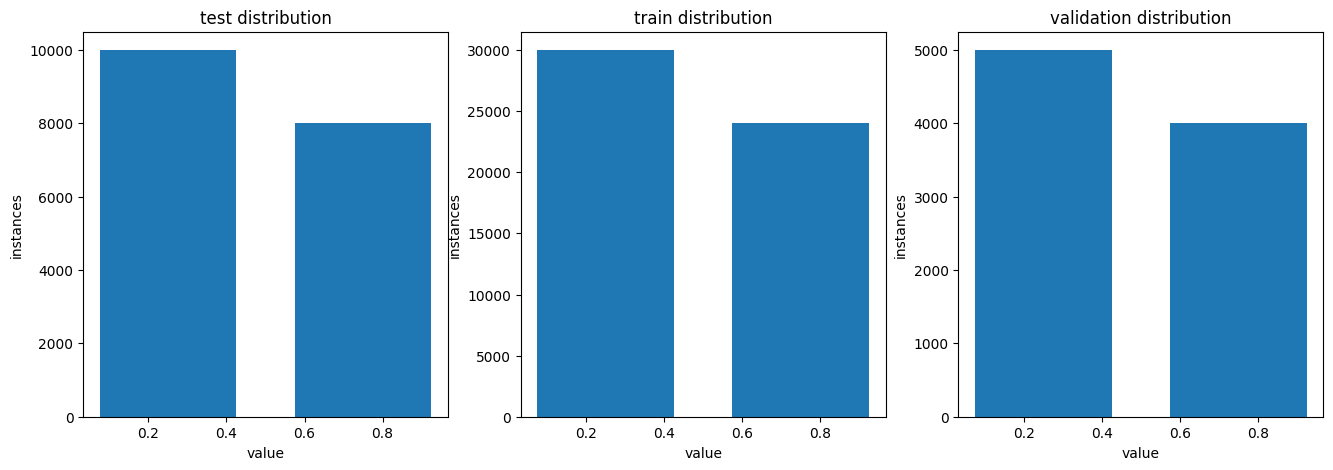

In [35]:
fig, ax = plt.subplots(1, 3, figsize = (16, 5))
ax[0].set_title("test distribution")
ax[0].hist(test_set_y, bins = 2, rwidth = 0.7)
ax[0].set_xlabel("value")
ax[0].set_ylabel("instances")

ax[1].set_title("train distribution")
ax[1].hist(train_set_y, bins = 2, rwidth = 0.7)
ax[1].set_xlabel("value")
ax[1].set_ylabel("instances")


ax[2].set_title("validation distribution")
ax[2].hist(valid_set_y, bins = 2, rwidth = 0.7)
ax[2].set_xlabel("value")
ax[2].set_ylabel("instances")
